## Numba Function - Running a Compiled C Callback Function 
This tutorial shows how to run custom operations written as Numba JIT-compiled functions.

The operator translates the user-defined function into a compiled function callable from external C code, eliminating the Python interpreter overhead.

Let's start by importing DALI and a handful of utilities.

In [1]:
from nvidia.dali import pipeline_def
import nvidia.dali as dali
import nvidia.dali.fn as fn
from nvidia.dali.plugin.numba.fn.experimental import numba_function
import nvidia.dali.types as dali_types

image_dir = "../data/images"
max_batch_size = 8

As an example, we'll write a pipeline which rotates images by 90 degrees. Since the output shape will be different than the input shape, we need to implement a setup function as well. In the setup function, we define the output data shapes in terms of the input shapes. Note that the setup function is invoked once for the whole batch. If the setup function is not provided, the operator assumes that the types and shapes of the outputs are the same as in the inputs.

#### Define the shape function swapping the width and height

In [2]:
def rot_image_setup(outs, ins):
    for i in range(len(outs)):
        for sample_idx in range(len(outs[i])):
            outs[i][sample_idx][0] = ins[i][sample_idx][1]
            outs[i][sample_idx][1] = ins[i][sample_idx][0]
            outs[i][sample_idx][2] = ins[i][sample_idx][2]

The setup function calculates the shapes of the outputs. It takes two arguments: a list of output shapes, which it fills, and a list of input shapes. The outer index applied to outs/ins is the index of the respective output/input; the inner index indicates the sample in the batch.

`outs[i]` - i-th output

`outs[i][j]` - get j-th sample of i-th output.

This function is compiled. It should be able to work in [nopython](https://numba.pydata.org/numba-doc/latest/user/5minguide.html#what-is-nopython-mode) mode.

#### Define the processing function that fills the output sample based on the input sample

In [3]:
def rot_image(out0, in0):
    for i in range(out0.shape[0]):
        for j in range(out0.shape[1]):
            out0[i][j] = in0[j][out0.shape[0] - i - 1]

The run function can have more than one input or output. The function with `n` outputs and `m` inputs should have following signature:
```
def run_fn(out_0, out_1, ..., out_n, in_0, in_1, ..., in_m):
```

By default, the numba function operator works on a per-sample basis. It's also possible to specify a function that processes a whole batch at once, by specifying the argument `batch_processing=True`. In this case, the outputs and inputs that the function receives contain a leading dimension, representing the sample index.


#### Define the Pipeline
To define the pipeline we pass the both the run and shape function to the DALI numba operator. We need to pass DALI types of inputs and outputs and dimensions of them.

In [4]:
@pipeline_def
def rotate_image_pipe(run_fn=None, setup_fn=None, out_types=None, in_types=None, outs_ndim=None, ins_ndim=None):
    files, labels = fn.readers.file(file_root=image_dir)
    images_in = dali.fn.decoders.image(files, device="cpu")
    return images_in, numba_function(images_in, 
                                 run_fn=run_fn, setup_fn=setup_fn,
                                 out_types=out_types, in_types=in_types, 
                                 outs_ndim=outs_ndim, ins_ndim=ins_ndim)

For more information about readers and decoders, please refer to [Getting Started](https://github.com/NVIDIA/DALI/blob/master/docs/examples/getting%20started.ipynb) notebook.

The next step is to build and run our pipeline.

In [5]:
pipe = rotate_image_pipe(batch_size=max_batch_size, num_threads=1,
                         device_id=0, run_fn=rot_image, setup_fn=rot_image_setup,
                         out_types=[dali_types.UINT8], in_types=[dali_types.UINT8],
                         outs_ndim=[3], ins_ndim=[3])
pipe.build()
images_in, images_out = pipe.run()

In [6]:
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
%matplotlib inline

def show_images(image_batch):
    columns = 4
    rows = (max_batch_size + 1) // (columns)
    fig = plt.figure(figsize = (8,(8 // columns) * rows))
    gs = gridspec.GridSpec(rows, columns)
    for j in range(rows*columns):
        plt.subplot(gs[j])
        plt.axis("off")
        plt.imshow(image_batch.at(j))

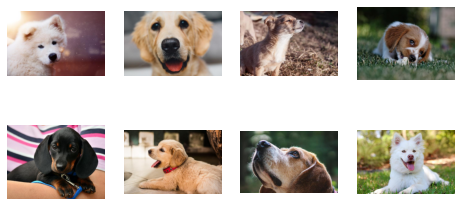

In [7]:
show_images(images_in)

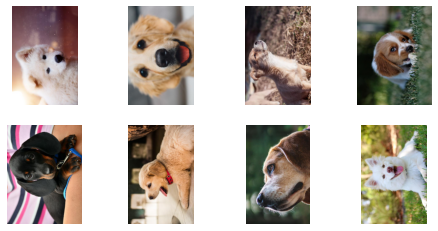

In [8]:
show_images(images_out)

### Multiple inputs and outputs
The numba function operator can take up to 6 inputs and produce up to 6 outputs. As an example, let us write a pipeline that takes an image and splits the RGB channels into 3 separate outputs

First, we need to define the setup function that defines the shapes of the outputs. The setup function may look like that:

In [9]:
def setup_split_rgb(outs, ins):
    out0 = outs[0]
    out1 = outs[1]
    out2 = outs[2]
    for r_shape, g_shape, b_shape, in_shape in zip(outs[0], outs[1], outs[2], ins[0]):
        r_shape[:] = g_shape[:] = b_shape[:] = in_shape[0:2]

The second step is to write the run function, that processes the data

In [10]:
def run_split_rgb(out0_batch, out1_batch, out2_batch, in0_batch):
    for R, G, B, in0 in zip(out0_batch, out1_batch, out2_batch, in0_batch):
        for i in range(in0.shape[0]):
            for j in range(in0.shape[1]):
                R[i][j] = in0[i][j][0]
                G[i][j] = in0[i][j][1]
                B[i][j] = in0[i][j][2]

In [11]:
@pipeline_def
def numba_function_split_rgb_pipe(run_fn=None, out_types=None, in_types=None, outs_ndim=None, ins_ndim=None, setup_fn=None):
    files, _ = fn.readers.file(file_root=image_dir)
    images_in = dali.fn.decoders.image(files, device="cpu")
    out0, out1, out2 = numba_function(images_in,
                                  run_fn=run_fn, setup_fn=setup_fn,
                                  out_types=out_types, in_types=in_types,
                                  outs_ndim=outs_ndim, ins_ndim=ins_ndim,
                                  batch_processing=True)
    return images_in, out0, out1, out2


In [12]:
pipe = numba_function_split_rgb_pipe(batch_size=max_batch_size, num_threads=3, device_id=0,
                                   run_fn=run_split_rgb, setup_fn=setup_split_rgb,
                                   out_types=[dali_types.UINT8 for _ in range(3)], in_types=[dali_types.UINT8],
                                   outs_ndim=[2, 2, 2], ins_ndim=[3])
pipe.build()
images_in, R, G, B = pipe.run()

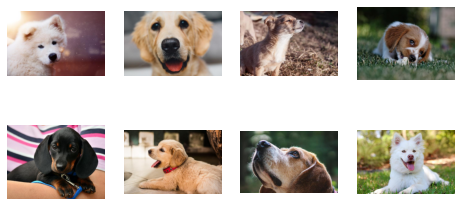

In [13]:
show_images(images_in)

In [14]:
import numpy as np
def show_images_rgb_planes(R, G, B):
    columns = 4
    rows = (max_batch_size + 1) // (columns)
    fig = plt.figure(figsize = (8,(8 // columns) * rows))
    gs = gridspec.GridSpec(rows, columns)
    for j in range(rows*columns):
        plt.subplot(gs[j])
        plt.axis("off")
        shape = None
        shape = R.at(j).shape if j < len(R) else shape
        shape = G.at(j).shape if j < len(G) else shape
        shape = B.at(j).shape if j < len(B) else shape
        plt.imshow(np.stack([R.at(j) if j < len(R) else np.zeros(shape, dtype=np.uint8),
                             G.at(j) if j < len(G) else np.zeros(shape, dtype=np.uint8),
                             B.at(j) if j < len(B) else np.zeros(shape, dtype=np.uint8)], axis=2))

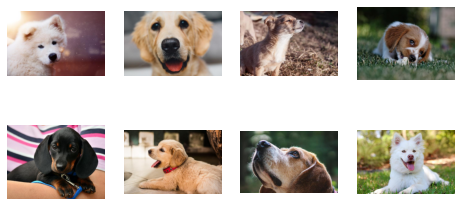

In [15]:
show_images_rgb_planes(R, G, B)

We can try showing images depending only on one channel and see if our pipeline is working correctly.

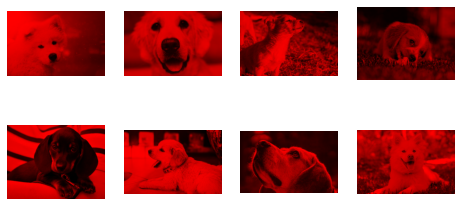

In [16]:
show_images_rgb_planes(R, [], [])

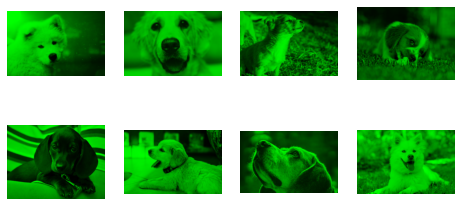

In [17]:
show_images_rgb_planes([], G, [])

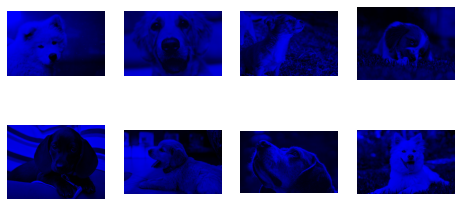

In [18]:
show_images_rgb_planes([], [], B)